# Анализ поведения пользователей в мобильном приложении

Ссылка на дашборд: https://public.tableau.com/views/dash_16798211079720/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Описание данных:

Колонки в *mobile_sources.csv:* 

- `userId` — идентификатор пользователя,
- `source` — источник, с которого пользователь установил приложение.

Колонки в *mobile_dataset.csv:*

- `event.time` — время совершения,
- `user.id` — идентификатор пользователя,
- `event.name` — действие пользователя.

Виды действий:

- `advert_open` — открыл карточки объявления,
- `photos_show` — просмотрел фотографий в объявлении,
- `tips_show` — увидел рекомендованные объявления,
- `tips_click` — кликнул по рекомендованному объявлению,
- `contacts_show` и `show_contacts` — посмотрел номер телефона,
- `contacts_call` — позвонил по номеру из объявления,
- `map` — открыл карту объявлений,
- `search_1`—`search_7` — разные действия, связанные с поиском по сайту,
- `favorites_add` — добавил объявление в избранное.

**Декомпозиция** 

Цель исследования: 
- Анализ связи целевого события — просмотра контактов — и других действий пользователей. 
- Оценить, какие действия чаще совершают те пользователи, которые просматривают контакты.

Шаг 1. Предобработка данных
- Замена названий столбцов на удобные;
- Проверка пропусков, дубликатов и типов данных, добавить столбец с датой и временем.

Шаг 2. Исследовательский анализ данных
- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данными за какой период я располагаю? 
- Какие события есть в логах, как часто они встречаются?
- Сколько пользователей совершали каждое из этих событий и доля пользователей, которые хоть раз совершали событие?

Шаг 3. Основная цель исследования
- Рассчитать количество сессий и среднее время, проведенное каждым пользователем в приложении;
- Какие сценарии использования приложения выделяются? В разрезе сессий выделить сценарии, визуализировать;
- Оценить, какие действия чаще совершают те пользователи, которые просматривают контакты;
- Проверить влияние событий (просмотр фото, добавление в избранное и пр.) на конверсию (матрица корреляций);
- Рассчитать конверсию по уникальным пользователям в целевое действие - contacts_show

Шаг 4. Проверка гипотез
- Одни пользователи совершают действия tips_show и tips_click, другие — только tips_show. Проверьте гипотезу: конверсия в просмотры контактов различается у этих двух групп.
- Одни пользователи совершают действия search и photos_show, другие — только search.

Шаг 5. Выводы.

In [91]:
import pandas as pd
import datetime as dt
from datetime import date, timedelta 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import numpy as np
import math as mth
import scipy.stats as stats
from scipy import stats as st
import tqdm
from tqdm import tqdm
import requests
from tqdm.notebook import tqdm as tqdm_notebook 

### Предобработка данных

Загрузим данные и подготовим их к анализу:

In [92]:
mobile_sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_sources.csv') 
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv') 

In [93]:
mobile_sources.head(3)

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex


In [94]:
mobile_dataset.head(3)

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c


####  Замена названий столбцов на удобные

Приведем названия столбцов к "змеиному" регистру:

In [95]:
mobile_sources = mobile_sources.rename(columns={'userId': 'user_id'})
mobile_dataset = mobile_dataset.rename(columns={'event.time': 'event_time', 
                                                'event.name': 'event_name', 
                                                'user.id': 'user_id'})

#### Проверка пропусков, дубликатов и типов данных, добавить столбец с датой и временем

Объединим таблицы по идентификатору пользователей и выполним дальнейшую предобработку уже общей таблицы:

In [96]:
df = mobile_sources.merge(mobile_dataset, on='user_id')
df.head(3)

,user_id,source,event_time,event_name
0,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00.431357,advert_open
1,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:01.236320,tips_show
2,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:07.039334,tips_show


Заменим тип данных у столбца со временем совершения события, добавим столбец с датой:

In [97]:
df['event_time'] = pd.to_datetime(df['event_time'], format ='%Y-%m-%d %H:%M:%S')
df['event_time'] = df['event_time'].dt.round('S') # округляем время до секунды
df['date'] = df['event_time'].dt.date
df['time'] = df['event_time'].dt.time
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     74197 non-null  object        
 1   source      74197 non-null  object        
 2   event_time  74197 non-null  datetime64[ns]
 3   event_name  74197 non-null  object        
 4   date        74197 non-null  object        
 5   time        74197 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 4.0+ MB


Проверим пропуски и явные дубликаты:

In [98]:
pd.DataFrame(round(df.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
user_id,0.000000
source,0.000000
event_time,0.000000
event_name,0.000000
date,0.000000
time,0.000000


In [99]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 1118


In [100]:
shape_0 = df.shape[0] # сохраним размер таблицы

In [101]:
df = df.drop_duplicates() # удаляем явные дубликаты 
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


In [102]:
print('После удаления дубликатов потеря данных составила:', round(100 - df.shape[0]*100 / shape_0, 2), '%.')

После удаления дубликатов потеря данных составила: 1.51 %.


In [103]:
df.head(3)

,user_id,source,event_time,event_name,date,time
0,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,advert_open,2019-10-07,00:00:00
1,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:01,tips_show,2019-10-07,00:00:01
2,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:07,tips_show,2019-10-07,00:00:07


В результате предобработки были удалены дубликаты, проверены пропуски, названия стобцов приведены к змеиному регистру, добавлены столбцы с датой и временем.

###  Исследовательский анализ данных

#### Посчитаем количество событий:

In [104]:
count_all_events = df['event_name'].count()
print('Общее количество событий:', count_all_events)
print('Уникальных событий:', df['event_name'].nunique())

Общее количество событий: 73079
Уникальных событий: 16


#### Посчитаем общее количество пользователей:

In [105]:
count_all_users = df['user_id'].nunique()
print('Общее количество пользователей:', count_all_users)

Общее количество пользователей: 4293


#### Проверим медианное значение количества событий на пользователя:

In [106]:
event_median = df.groupby('user_id')['event_name'].count()
event_median.describe()

count    4293.000000
mean       17.022828
std        28.617646
min         1.000000
25%         5.000000
50%         9.000000
75%        17.000000
max       472.000000
Name: event_name, dtype: float64

Медианное значение за весь период составляет 9 событий на пользователя. 

#### Проверим минимальную и максимальную даты:

In [107]:
print('Минимальная дата:', df['date'].min())
print('Максимальная дата:',df['date'].max())

Минимальная дата: 2019-10-07
Максимальная дата: 2019-11-03


Мы располагаем данными с 7 октября по 3 ноября 2019 г.

Визуализируем количество событий по дням:

In [108]:
events_dates = df.groupby('date')['event_name'].count().reset_index()
fig = px.bar(events_dates, y="event_name", x="date")

fig.update_layout(title="Количество событий по дням",
                   xaxis_title='Дата',
                   yaxis_title='Колчество событий',
                   yaxis={'categoryorder':'total ascending'},
                   legend_title="Категория")
fig.update_layout(showlegend=False)
fig.show()

В течение изучаемого периода активность пользователей колебалась. Дни с аномально низкой и высокой активностью отсутствуют, данные за все дни пригодны для анализа.

#### Какие события есть в логах, как часто они встречаются:

In [109]:
df['event_name'].value_counts()

tips_show        39892
photos_show       9372
advert_open       6145
contacts_show     4302
map               3760
search_1          3489
favorites_add     1414
search_5          1049
tips_click         811
search_4           701
contacts_call      538
search_3           521
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64

Собитытия contacts_show и show_contacts вероятнее всего являются неявными дубликатами, считаю корректным объединить их:

In [110]:
df['event_name'] = df['event_name'].replace('show_contacts', 'contacts_show')
df['event_name'].value_counts()

tips_show        39892
photos_show       9372
advert_open       6145
contacts_show     4381
map               3760
search_1          3489
favorites_add     1414
search_5          1049
tips_click         811
search_4           701
contacts_call      538
search_3           521
search_6           460
search_2           324
search_7           222
Name: event_name, dtype: int64

События search_1 - search_7 - разные действия, связанные с поиском по сайту. Их также объединим:

In [111]:
def event_search(i):
    if 'search' in i:
        new_name = 'search'
        return new_name
    return i

df['event_name'] = df['event_name'].apply(event_search)

#### Посчитаем, сколько пользователей совершали каждое из этих событий и долю пользователей, которые хоть раз совершали событие.

In [112]:
users_events = df.groupby('event_name').agg({'event_name':'count', 'user_id':'nunique'}).sort_values(by='user_id', ascending=False)
count_users = df['user_id'].nunique()
users_events['users_share'] = (users_events['user_id'] / count_users * 100).round(1)
users_events.columns = ['count_event', 'count_users', 'users_share']
users_events = users_events.reset_index()
users_events

,event_name,count_event,count_users,users_share
0,tips_show,39892,2801,65.2
1,search,6766,1666,38.8
2,map,3760,1456,33.9
3,photos_show,9372,1095,25.5
4,contacts_show,4381,981,22.9
5,advert_open,6145,751,17.5
6,favorites_add,1414,351,8.2
7,tips_click,811,322,7.5
8,contacts_call,538,213,5.0


In [113]:
fig = px.bar(users_events, y="event_name", x="count_users", text='count_users', color = 'event_name')

fig.update_layout(title="Сколько пользователей совершали каждое из событий",
                   xaxis_title='Количество пользователей',
                   yaxis_title='События',
                   yaxis={'categoryorder':'total ascending'},
                   legend_title="Категория")
fig.update_layout(showlegend=False)
fig.show()

Вероятнее всего, tips_show показывается всем пользователям автоматически и не зависит от его действий. <br> В ТОП - 3 действий входят search, map, photos_show.<br> Целевое действие совершают 23% всех пользователей.

### Основная цель исследования

####  Выделим сессии относительно тайм-аута. 
Тайм-аут - это время бездействия посетителя на сайте. По истечении указанного количества минут визит будет считаться завершенным, по умолчанию составляет 30 минут. Источник: https://yandex.ru/support/metrica/general/counter-general.html
<br> Если между событиями прошло более 30 минут, то их определим к разным сессиям:

In [114]:
df['pre_time'] = df.groupby('user_id')['event_time'].shift() # время предыдущего действия пользователя
df.head(3)

,user_id,source,event_time,event_name,date,time,pre_time
0,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,advert_open,2019-10-07,00:00:00,NaT
1,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:01,tips_show,2019-10-07,00:00:01,2019-10-07 00:00:00
2,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:07,tips_show,2019-10-07,00:00:07,2019-10-07 00:00:01


In [115]:
df['time_between_event'] = df['event_time'] - df['pre_time'] # время между событиями
df.head(3)

,user_id,source,event_time,event_name,date,time,pre_time,time_between_event
0,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,advert_open,2019-10-07,00:00:00,NaT,NaT
1,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:01,tips_show,2019-10-07,00:00:01,2019-10-07 00:00:00,0 days 00:00:01
2,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:07,tips_show,2019-10-07,00:00:07,2019-10-07 00:00:01,0 days 00:00:06


In [116]:
g = (df.groupby('user_id')['event_time'].diff() > pd.Timedelta('30Min')).cumsum()
df['session_id'] = df.groupby(['user_id', g], sort=False).ngroup() + 1 # создаем счетчик
df.head(3)

,user_id,source,event_time,event_name,date,time,pre_time,time_between_event,session_id
0,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,advert_open,2019-10-07,00:00:00,NaT,NaT,1
1,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:01,tips_show,2019-10-07,00:00:01,2019-10-07 00:00:00,0 days 00:00:01,1
2,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:07,tips_show,2019-10-07,00:00:07,2019-10-07 00:00:01,0 days 00:00:06,1


In [117]:
# время между событиями длиннее 30 минут заменяем на NaN
df['time_between_event'].loc[(df['time_between_event'] > pd.Timedelta(30,'m'))] = np.nan
df.head()

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,user_id,source,event_time,event_name,date,time,pre_time,time_between_event,session_id
0,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,advert_open,2019-10-07,00:00:00,NaT,NaT,1
1,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:01,tips_show,2019-10-07,00:00:01,2019-10-07 00:00:00,0 days 00:00:01,1
2,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:07,tips_show,2019-10-07,00:00:07,2019-10-07 00:00:01,0 days 00:00:06,1
3,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:01:28,advert_open,2019-10-07,00:01:28,2019-10-07 00:00:07,0 days 00:01:21,1
4,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:01:35,tips_show,2019-10-07,00:01:35,2019-10-07 00:01:28,0 days 00:00:07,1


Рассчитаем среднюю продолжительность сессий:

In [118]:
total_session = df.groupby(['user_id','session_id'], as_index=False).agg({'time_between_event':'sum'})
total_session = total_session.rename(columns={'time_between_event': 'session_duration'})
total_session.head(3)

,user_id,session_id,session_duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,251,0 days 00:09:56
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,252,0 days 00:08:27
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,253,0 days 00:14:59


In [119]:
total_session['session_duration'].describe()

count                        10368
mean     0 days 00:12:52.668981481
std      0 days 00:19:51.607952024
min                0 days 00:00:00
25%                0 days 00:00:21
50%                0 days 00:05:35
75%         0 days 00:17:25.250000
max                0 days 05:21:58
Name: session_duration, dtype: object

Уберем из анализа сессии с нулевой продолжительностью, т.к. такие данные не пригодны для анализа - возможно, пользователь открыл приложение по ошибке:

In [120]:
total_session = total_session[total_session['session_duration'] > '0 days 00:00:00']
total_session['session_duration'].describe()

count                         8226
mean     0 days 00:16:13.867250182
std      0 days 00:21:02.438585585
min                0 days 00:00:01
25%                0 days 00:03:10
50%                0 days 00:09:18
75%         0 days 00:21:35.750000
max                0 days 05:21:58
Name: session_duration, dtype: object

Рассчитаем медианное количество сессий на пользователя:

In [121]:
total_session.groupby('user_id')['session_id'].count().median()

1.0

И количество событий за сессию:

In [122]:
df.groupby('session_id')['event_name'].count().median()

4.0

In [123]:
df.head()

,user_id,source,event_time,event_name,date,time,pre_time,time_between_event,session_id
0,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,advert_open,2019-10-07,00:00:00,NaT,NaT,1
1,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:01,tips_show,2019-10-07,00:00:01,2019-10-07 00:00:00,0 days 00:00:01,1
2,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:07,tips_show,2019-10-07,00:00:07,2019-10-07 00:00:01,0 days 00:00:06,1
3,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:01:28,advert_open,2019-10-07,00:01:28,2019-10-07 00:00:07,0 days 00:01:21,1
4,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:01:35,tips_show,2019-10-07,00:01:35,2019-10-07 00:01:28,0 days 00:00:07,1


In [124]:
df1 = df[['user_id', 'source', 'event_name', 'date']]
df1.to_csv('df1')

Среднестатистический пользователь приложения заходил в приложение 1 раз, проводил там около 9 минут. Медианное количество действий на пользователя за сессию - 4.

#### Какие сценарии использования приложения выделяются? 
В разрезе сессий выделим сценарии, визуализируем с помощью диаграммы Сэнкея.

In [125]:
df1 = df[['user_id','session_id', 'event_time', 'event_name']]
df1.head(3)

,user_id,session_id,event_time,event_name
0,020292ab-89bc-4156-9acf-68bc2783f894,1,2019-10-07 00:00:00,advert_open
1,020292ab-89bc-4156-9acf-68bc2783f894,1,2019-10-07 00:00:01,tips_show
2,020292ab-89bc-4156-9acf-68bc2783f894,1,2019-10-07 00:00:07,tips_show


In [126]:
def add_features(table):
    
    # сортируем по id и времени
    sorted_df = table.sort_values(by=['session_id', 'event_time']).copy()
    # добавляем шаги событий
    sorted_df['step'] = sorted_df.groupby('session_id').cumcount() + 1
    
    # добавляем узлы-источники и целевые узлы
    # узлы-источники - это сами события
    sorted_df['source'] = sorted_df['event_name']
    # добавляем целевые узлы
    sorted_df['target'] = sorted_df.groupby('session_id')['source'].shift(-1)
    sorted_df = sorted_df.query('source != target')
    
    # возврат таблицы без имени событий
    return sorted_df.drop(['event_name'], axis=1)
  
# преобразуем таблицу
table = add_features(df1)
table.head()

,user_id,session_id,event_time,step,source,target
0,020292ab-89bc-4156-9acf-68bc2783f894,1,2019-10-07 00:00:00,1,advert_open,tips_show
2,020292ab-89bc-4156-9acf-68bc2783f894,1,2019-10-07 00:00:07,3,tips_show,advert_open
3,020292ab-89bc-4156-9acf-68bc2783f894,1,2019-10-07 00:01:28,4,advert_open,tips_show
4,020292ab-89bc-4156-9acf-68bc2783f894,1,2019-10-07 00:01:35,5,tips_show,advert_open
5,020292ab-89bc-4156-9acf-68bc2783f894,1,2019-10-07 00:01:55,6,advert_open,tips_show


Найдем количество сессий на каждом шаге:

In [127]:
table1 = table.groupby('step')['session_id'].nunique().reset_index()
table1.head()

,step,session_id
0,1,5036
1,2,3701
2,3,2933
3,4,2473
4,5,2011


In [128]:
fig = px.bar(table1, x = "step", y = "session_id", title='Количество сессий на каждом шаге')
fig.update_xaxes(title_text='Количество шагов') 
fig.update_yaxes(title_text='Пользователи')
fig.show() 

Большинство сессий содержит до 10 шагов.

In [129]:
table_top = table1.head(10)
fig = px.bar(table_top, x = "step", y = "session_id", title='Количество сессий на каждом шаге', text="session_id")
fig.update_xaxes(title_text='Категория') 
fig.update_yaxes(title_text='Количество')
fig.show() 

Для наглядности диаграммы Санкея удалим сессии, в которых было совершено от 5 шагов.

In [130]:
# удалим все пары source-target, шаг которых превышает 5
# и сохраним полученную таблицу в отдельную переменную
df_comp = table[table['step'] <= 5].copy().reset_index(drop=True)

In [131]:
def get_source_index(df):
    
    """Функция генерации индексов source

    Args:
        df (pd.DataFrame): исходная таблица с признаками step, source, target.
    Returns:
        dict: словарь с индексами, именами и соответсвиями индексов именам source.
    """
    
    res_dict = {}
    
    count = 0
    # получаем индексы источников
    for no, step in enumerate(df['step'].unique().tolist()):
        # получаем уникальные наименования для шага
        res_dict[no+1] = {}
        res_dict[no+1]['sources'] = df[df['step'] == step]['source'].unique().tolist()
        res_dict[no+1]['sources_index'] = []
        for i in range(len(res_dict[no+1]['sources'])):
            res_dict[no+1]['sources_index'].append(count)
            count += 1
            
    # соединим списки
    for key in res_dict:
        res_dict[key]['sources_dict'] = {}
        for name, no in zip(res_dict[key]['sources'], res_dict[key]['sources_index']):
            res_dict[key]['sources_dict'][name] = no
    return res_dict
  

# создаем словарь
source_indexes = get_source_index(df_comp)

In [132]:
def generate_random_color():
    
    """Случайная генерация цветов rgba

    Args:
        
    Returns:
        str: Строка со сгенерированными параметрами цвета
    """
    
    # сгенерим значение для каждого канала
    r, g, b = np.random.randint(255, size=3)
    return f'rgba({r}, {g}, {b}, 1)'

In [133]:
def colors_for_sources(mode):
    
    """Генерация цветов rgba

    Args:
        mode (str): сгенерировать случайные цвета, если 'random', а если 'custom' - 
                    использовать заранее подготовленные
    Returns:
        dict: словарь с цветами, соответствующими каждому индексу
    """
    # словарь, в который сложим цвета в соответствии с индексом
    colors_dict = {}
    
    if mode == 'random':
        # генерим случайные цвета
        for label in df_comp['source'].unique():
            r, g, b = np.random.randint(255, size=3)            
            colors_dict[label] = f'rgba({r}, {g}, {b}, 1)'
            
    elif mode == 'custom':
        # присваиваем ранее подготовленные цвета
        colors = requests.get('https://raw.githubusercontent.com/rusantsovsv/senkey_tutorial/main/json/colors_senkey.json').json()
        for no, label in enumerate(df_comp['source'].unique()):
            colors_dict[label] = colors['custom_colors'][no]
            
    return colors_dict
  
  
 #генерю цвета из своего списка
colors_dict = colors_for_sources(mode='custom')

In [134]:
def percent_users(sources, targets, values):
    
    """
    Расчет уникальных id в процентах (для вывода в hover text каждого узла)
    
    Args:
        sources (list): список с индексами source.
        targets (list): список с индексами target.
        values (list): список с "объемами" потоков.
        
    Returns:
        list: список с "объемами" потоков в процентах
    """
    
    # объединим источники и метки и найдем пары
    zip_lists = list(zip(sources, targets, values))
    
    new_list = []
    
    # подготовим список словарь с общим объемом трафика в узлах
    unique_dict = {}
    
    # проходим по каждому узлу
    for source, target, value in zip_lists:
        if source not in unique_dict:
            # находим все источники и считаем общий трафик
            unique_dict[source] = 0
            for sr, tg, vl in zip_lists:
                if sr == source:
                    unique_dict[source] += vl
                    
    # считаем проценты
    for source, target, value in zip_lists:
        new_list.append(round(100 * value / unique_dict[source], 1))
    
    return new_list

In [135]:
def lists_for_plot(source_indexes=source_indexes, colors=colors_dict, frac=10):
    
    """
    Создаем необходимые для отрисовки диаграммы переменные списков и возвращаем
    их в виде словаря
    
    Args:
        source_indexes (dict): словарь с именами и индексами source.
        colors (dict): словарь с цветами source.
        frac (int): ограничение на минимальный "объем" между узлами.
        
    Returns:
        dict: словарь со списками, необходимыми для диаграммы.
    """
    
    sources = []
    targets = []
    values = []
    labels = []
    link_color = []
    link_text = []

    # проходим по каждому шагу
    for step in tqdm_notebook(sorted(df_comp['step'].unique()), desc='Шаг'):
        if step + 1 not in source_indexes:
            continue

        # получаем индекс источника
        temp_dict_source = source_indexes[step]['sources_dict']

        # получаем индексы цели
        temp_dict_target = source_indexes[step+1]['sources_dict']

        # проходим по каждой возможной паре, считаем количество таких пар
        for source, index_source in tqdm_notebook(temp_dict_source.items()):
            for target, index_target in temp_dict_target.items():
                # делаем срез данных и считаем количество id            
                temp_df = df_comp[(df_comp['step'] == step)&(df_comp['source'] == source)&(df_comp['target'] == target)]
                value = len(temp_df)
                # проверяем минимальный объем потока и добавляем нужные данные
                if value > frac:
                    sources.append(index_source)
                    targets.append(index_target)
                    values.append(value)
                    # делаем поток прозрачным для лучшего отображения
                    link_color.append(colors[source].replace(', 1)', ', 0.2)'))
                    
    labels = []
    colors_labels = []
    for key in source_indexes:
        for name in source_indexes[key]['sources']:
            labels.append(name)
            colors_labels.append(colors[name])
            
    # посчитаем проценты всех потоков
    perc_values = percent_users(sources, targets, values)
    
    # добавим значения процентов для howertext
    link_text = []
    for perc in perc_values:
        link_text.append(f"{perc}%")
    
    # возвратим словарь с вложенными списками
    return {'sources': sources, 
            'targets': targets, 
            'values': values, 
            'labels': labels, 
            'colors_labels': colors_labels, 
            'link_color': link_color, 
            'link_text': link_text}
  

# создаем словарь
data_for_plot = lists_for_plot()

Шаг:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [136]:
def plot_senkey_diagram(data_dict=data_for_plot):    
    
    """
    Функция для генерации объекта диаграммы Сенкей 
    
    Args:
        data_dict (dict): словарь со списками данных для построения.
        
    Returns:
        plotly.graph_objs._figure.Figure: объект изображения.
    """
    
    fig = go.Figure(data=[go.Sankey(
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
          pad = 50,
          thickness = 15,
          line = dict(color = "black", width = 0.1),
          label = data_dict['labels'],
          color = data_dict['colors_labels']
        ),
        link = dict(
          source = data_dict['sources'],
          target = data_dict['targets'],
          value = data_dict['values'],
          label = data_dict['link_text'],
          color = data_dict['link_color']
      ))])
    fig.update_layout(title_text="Sankey Diagram", font_size=10, width=1000, height=700)
    
    # возвращаем объект диаграммы
    return fig
  

# сохраняем диаграмму в переменную
senkey_diagram = plot_senkey_diagram()
senkey_diagram.show()

In [137]:
df['event_name'].value_counts()

tips_show        39892
photos_show       9372
search            6766
advert_open       6145
contacts_show     4381
map               3760
favorites_add     1414
tips_click         811
contacts_call      538
Name: event_name, dtype: int64

По диаграмме предположим, в каком порядке происходят события. 
Самым популярным является действие tips_show, затем photos_show, search, advert_open и целевое - contacts_show. 
То есть пользователь видит рекомендованные объявления, открывает карточки этих объявлений, часто смотрит фото, и совершает целевое действие - смотрит номер телефона. 

Вариант 1: 
- map - открыл карту объявлений
- tips_show - увидел рекомендованные объявления
- contacts_show - посмотрел номер телефона

Вариант 2: 
- tips_show - увидел рекомендованные объявления
- contacts_show - посмотрел номер телефона

Вариант 3: 
- photos_show — просмотрел фотографий в объявлении
- contacts_show - посмотрел номер телефона

Вариант 4: 
- advert_open - открыл карту объявлений
- tips_show - увидел рекомендованные объявления
- contacts_show - посмотрел номер телефона

Вариант 5: 
- search - разные действия, связанные с поиском по сайту
- photos_show — просмотрел фотографий в объявлении
- contacts_show - посмотрел номер телефона

Вариант 6: 
- search - разные действия, связанные с поиском по сайту
- contacts_show - посмотрел номер телефона

In [138]:
df.head()

,user_id,source,event_time,event_name,date,time,pre_time,time_between_event,session_id
0,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,advert_open,2019-10-07,00:00:00,NaT,NaT,1
1,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:01,tips_show,2019-10-07,00:00:01,2019-10-07 00:00:00,0 days 00:00:01,1
2,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:07,tips_show,2019-10-07,00:00:07,2019-10-07 00:00:01,0 days 00:00:06,1
3,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:01:28,advert_open,2019-10-07,00:01:28,2019-10-07 00:00:07,0 days 00:01:21,1
4,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:01:35,tips_show,2019-10-07,00:01:35,2019-10-07 00:01:28,0 days 00:00:07,1


In [139]:
users = df.pivot_table(index=['user_id'], 
                         columns='event_name', 
                         values='event_time',
                         aggfunc='min').reset_index()
users.head()

event_name,user_id,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,tips_show
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,NaT,NaT,NaT,NaT,2019-10-09 18:33:56,NaT,NaT,NaT,2019-10-07 13:39:46
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-24 10:52:19,2019-10-20 19:17:25,2019-10-20 19:17:19,2019-10-20 19:03:02,NaT,2019-10-19 21:40:39,2019-10-19 21:34:34,NaT,NaT
2,00463033-5717-4bf1-91b4-09183923b9df,NaT,NaT,NaT,NaT,NaT,2019-11-01 13:54:35,NaT,NaT,NaT
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-27 00:08:28,NaT,NaT,NaT,2019-10-18 22:17:41,NaT,2019-10-18 22:14:06,NaT,2019-10-20 17:48:42
4,00551e79-152e-4441-9cf7-565d7eb04090,NaT,2019-10-25 16:44:45,2019-10-25 16:44:41,NaT,NaT,2019-10-29 02:17:12,2019-10-28 13:08:16,NaT,NaT


In [140]:
# функция для воронок с 3 шагами

def funnels(first, second, third):
  step_1 = ~users[first].isna()
  step_2 = step_1 & (users[second] > users[first])
  step_3 = step_2 & (users[third] > users[second])
  
  title=str('"<b>Воронка событий: ' + first + ' - ' + second + ' - ' + third +'</b>"')

  n_1 = users[step_1].shape[0]
  n_2 = users[step_2].shape[0]
  n_3 = users[step_3].shape[0]
 

  fig = go.Figure(go.Funnel(
    y = [first, second, third],
    x = [n_1, n_2, n_3],
    textposition = "auto",
    textinfo = "value+percent initial+percent previous",
    opacity = 0.65, marker = {"color": ["lightgreen", "mediumaquamarine", "mediumseagreen"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["lightgreen", "mediumaquamarine", "mediumseagreen"]}},
    connector = {"line": {"color": "lightgreen", "dash": "dot", "width": 3}})
    )
  fig.update_layout(title=str('<b>Воронка событий: ' + first + ' - ' + second + ' - ' + third +'</b>'))
  fig.show()

In [141]:
# функция для воронок с 2 шагами

def funnels_2(first, second):
  step_1 = ~users[first].isna()
  step_2 = step_1 & (users[second] > users[first])
  
  title=str('"<b>Воронка событий: ' + first + ' - ' + second + ' - ' +'</b>"')

  n_1 = users[step_1].shape[0]
  n_2 = users[step_2].shape[0]
 

  fig = go.Figure(go.Funnel(
    y = [first, second],
    x = [n_1, n_2],
    textposition = "auto",
    textinfo = "value+percent initial+percent previous",
    opacity = 0.65, marker = {"color": ["lightgreen", "mediumaquamarine", "mediumseagreen"],
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": ["lightgreen", "mediumaquamarine", "mediumseagreen"]}},
    connector = {"line": {"color": "lightgreen", "dash": "dot", "width": 1}})
    )
  fig.update_layout(title=str('<b>Воронка событий: ' + first + ' - ' + second + '</b>'))
  fig.show()

In [142]:
funnels('map', 'tips_show', 'contacts_show')

In [143]:
funnels_2('tips_show', 'contacts_show') 

In [144]:
funnels_2('photos_show', 'contacts_show') 

In [145]:
funnels('advert_open', 'tips_show', 'contacts_show')

In [146]:
funnels('search', 'photos_show', 'contacts_show')

In [147]:
funnels_2('search', 'contacts_show')

Это наиболее популярные сценарии пользователей, совершивших целевое действие. Чаще всего совершают целевое действие после события 'photos_show'. 

#### Посмотрим, какие действия чаще совершают те пользователи, которые доходят до целевого действия - просмотра контактов:

Для этого выделим в отдельную таблицу пользователей, совершивших целевое действие.

In [148]:
users_show_contacts = df[df['event_name']=='contacts_show']['user_id'].unique()
users_show_contacts = df[df['user_id'].isin(users_show_contacts)]
users_show_contacts.head()

,user_id,source,event_time,event_name,date,time,pre_time,time_between_event,session_id
121,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,2019-10-07 00:02:07,tips_show,2019-10-07,00:02:07,NaT,NaT,9
122,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,2019-10-07 00:05:16,contacts_show,2019-10-07,00:05:16,2019-10-07 00:02:07,0 days 00:03:09,9
123,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,2019-10-07 00:06:01,tips_show,2019-10-07,00:06:01,2019-10-07 00:05:16,0 days 00:00:45,9
124,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,2019-10-07 00:06:56,tips_show,2019-10-07,00:06:56,2019-10-07 00:06:01,0 days 00:00:55,9
125,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,2019-10-07 00:09:25,tips_show,2019-10-07,00:09:25,2019-10-07 00:06:56,0 days 00:02:29,9


In [149]:
users_show1 = users_show_contacts.groupby('event_name')['user_id'].count().reset_index()
users_show1 = users_show1.query('event_name!="contacts_show" and event_name!="tips_show"')
users_show1.sort_values(by='user_id', ascending=False).reset_index()

,index,event_name,user_id
0,5,photos_show,3497
1,6,search,2082
2,0,advert_open,1585
3,4,map,1066
4,1,contacts_call,538
5,3,favorites_add,421
6,7,tips_click,332


In [150]:
fig = px.bar(users_show1, 
             x='user_id', 
             y='event_name', 
             text='user_id'
            )

fig.update_layout(title='Действия пользователей, совершивших целевое событие',
                   xaxis_title='Количество пользователей',
                   yaxis_title='Действия',
                   yaxis={'categoryorder':'total ascending'})
fig.update_layout(showlegend=False)
fig.show() 

Сравним с диаграммой по действиям всех пользователей:

In [151]:
users_events = users_events.query('event_name!= "tips_show"')
fig = px.bar(users_events, y="event_name", x="count_users", text='count_users')

fig.update_layout(title="Действия всех пользователей",
                   xaxis_title='Количество пользователей',
                   yaxis_title='Действия',
                   yaxis={'categoryorder':'total ascending'},
                   legend_title="Категория")
fig.update_layout(showlegend=False)
fig.show()

Пользователи, выполнившие целевое действие часто совершают такие действия как photos_show - просмотрел фотографий в объявлении, search - разные действия, связанные с поиском по сайту, advert_open - открыл карточки объявления, map - открыл карту объявлений.

Следует поработать над кнопкой поиска - она популярна у целевых пользователей. Также целевая аудитория любит смотреть фото вещей - обратить внимание на разрешение/формат, по возможности добавить видео.

#### Проверить влияние событий (просмотр фото, добавление в избранное и пр.) на конверсию

Рассчитаем количество действий каждого пользователя:

In [152]:
all_users = df.pivot_table(index = 'user_id', columns = 'event_name', values = 'event_time', aggfunc = ('count'))
all_users.head()

event_name,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,tips_show
user_id,,,,,,,,,
0001b1d5-b74a-4cbf-aeb0-7df5947bf349,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,29.0
00157779-810c-4498-9e05-a1e9e3cedf93,2.0,5.0,11.0,2.0,NaN,33.0,18.0,NaN,NaN
00463033-5717-4bf1-91b4-09183923b9df,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN
004690c3-5a84-4bb7-a8af-e0c8f8fca64e,5.0,NaN,NaN,NaN,6.0,NaN,17.0,NaN,4.0
00551e79-152e-4441-9cf7-565d7eb04090,NaN,3.0,3.0,NaN,NaN,1.0,1.0,NaN,NaN


In [153]:
all_users.fillna(0, inplace = True) # заменяю пропуски на 0
all_users.loc[(all_users.contacts_show > 0), 'contacts_show'] = 1 # ставлю метку на целевом событии
all_users['contacts_show'].value_counts()

0.0    3312
1.0     981
Name: contacts_show, dtype: int64

Построим тепловую карту корреляции между действиями:

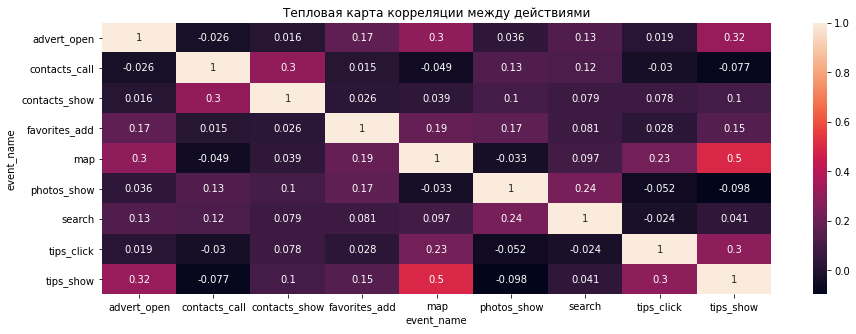

In [154]:
cm = all_users.corr()
plt.figure(figsize=(15, 5))
sns.heatmap(data = cm, annot = True)
plt.title('Тепловая карта корреляции между действиями')
plt.show()

Максимальный коэффициант корреляции составил 0.5 - наибольшая зависимость наблюдается между целевым действием и "map" (открыл карту объявлений). В целом сильной зависимости между действиями пользователей не выявлено.

#### Рассчитать конверсию по уникальным пользователям в целевое действие - contacts_show
Для этого посмотрим, сколько пользователей совершили каждое из действий и найдем, сколько из них посмотрели контакт:

In [155]:
users_events # таблица по всем пользователям

,event_name,count_event,count_users,users_share
1,search,6766,1666,38.8
2,map,3760,1456,33.9
3,photos_show,9372,1095,25.5
4,contacts_show,4381,981,22.9
5,advert_open,6145,751,17.5
6,favorites_add,1414,351,8.2
7,tips_click,811,322,7.5
8,contacts_call,538,213,5.0


In [156]:
users_show_contacts.head(3) # таблица с действиями пользователей, среди которых есть целевое событие

,user_id,source,event_time,event_name,date,time,pre_time,time_between_event,session_id
121,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,2019-10-07 00:02:07,tips_show,2019-10-07,00:02:07,NaT,NaT,9
122,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,2019-10-07 00:05:16,contacts_show,2019-10-07,00:05:16,2019-10-07 00:02:07,0 days 00:03:09,9
123,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex,2019-10-07 00:06:01,tips_show,2019-10-07,00:06:01,2019-10-07 00:05:16,0 days 00:00:45,9


Посчитаем, сколько уникальных пользователей, совершивших целевое действие, выполнили каждое из действий:

In [157]:
users_show_contacts1 = (
    users_show_contacts.groupby('event_name')
    .agg({'user_id':'nunique'})
    .sort_values(by = 'user_id', ascending=False)
)
users_show_contacts1.columns = ['user_cnt']
users_show_contacts1 = users_show_contacts1.reset_index()
users_show_contacts1

,event_name,user_cnt
0,contacts_show,981
1,tips_show,516
2,search,377
3,photos_show,339
4,map,289
5,contacts_call,213
6,advert_open,138
7,favorites_add,136
8,tips_click,100


Объединим 2 таблицы выше:

In [158]:
users_show_contacts2 = users_events.merge(users_show_contacts1, on = 'event_name')
users_show_contacts2 = users_show_contacts2[['event_name','count_users', 'user_cnt']]
users_show_contacts2 = users_show_contacts2.rename(columns={'count_users': 'all_users', 'user_cnt':'users_part'}) 
users_show_contacts2

,event_name,all_users,users_part
0,search,1666,377
1,map,1456,289
2,photos_show,1095,339
3,contacts_show,981,981
4,advert_open,751,138
5,favorites_add,351,136
6,tips_click,322,100
7,contacts_call,213,213


Добавим столбец с конверсией:

In [159]:
users_show_contacts2['conversion'] = round(users_show_contacts2['users_part']*100 / users_show_contacts2['all_users'], 1)
users_show_contacts2.sort_values(by='conversion', ascending=False)

,event_name,all_users,users_part,conversion
3,contacts_show,981,981,100.0
7,contacts_call,213,213,100.0
5,favorites_add,351,136,38.7
6,tips_click,322,100,31.1
2,photos_show,1095,339,31.0
0,search,1666,377,22.6
1,map,1456,289,19.8
4,advert_open,751,138,18.4


Все пользователи, позвонившие по номеру из объявления, предварительно просматривают контакты. Относительно высокая конверсия у действий "favorites_add" (39%), tips_click и photos_show (по 31%).

### Проверка гипотез

#### Одни пользователи совершают действия tips_show и tips_click, другие — только tips_show. 
Проверьте гипотезу: конверсия в просмотры контактов различается у этих двух групп.

H0 - Конверсии пользователей, которые совершают действия tips_show и tips_click, и пользователей, совершающих только tips_show в просмотры контактов равны. <br> H1 - Конверсии пользователей, которые совершают действия tips_show и tips_click, и пользователей, совершающих только tips_show в просмотры контактов не равны.

Выделим пользователей, которые делают и tips_show, и tips_click, посчитаем их количество и узнаем, сколько из них делают целевое действие.
Тоже самое проделаем с группой, которые делаеют только только tips_show.

In [160]:
a = df.pivot_table(index=['user_id'], 
                         columns='event_name', 
                         values='event_time',
                         aggfunc='count').reset_index()
a.head()

event_name,user_id,advert_open,contacts_call,contacts_show,favorites_add,map,photos_show,search,tips_click,tips_show
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,29.0
1,00157779-810c-4498-9e05-a1e9e3cedf93,2.0,5.0,11.0,2.0,NaN,33.0,18.0,NaN,NaN
2,00463033-5717-4bf1-91b4-09183923b9df,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,5.0,NaN,NaN,NaN,6.0,NaN,17.0,NaN,4.0
4,00551e79-152e-4441-9cf7-565d7eb04090,NaN,3.0,3.0,NaN,NaN,1.0,1.0,NaN,NaN


Разделим пользователей на 2 группы: 
1. которые делают и tips_show, и tips_click <br>
2. только tips_show.

In [161]:
show_click = a.query('tips_show.notnull() and tips_click.notnull()').reset_index()
show = a.query('tips_show.notnull() and tips_click.isna()').reset_index()

Проверим, остались ли у нас пользователи, попавшие в обе группы:

In [162]:
show_click.merge(show, on = 'user_id', how = 'inner')['user_id'].count()

0

In [163]:
print('Пользователей, совершивших и tips_show, и tips_click:', show_click['user_id'].nunique())

Пользователей, совершивших и tips_show, и tips_click: 297


In [164]:
print('Пользователей, совершивших только tips_show:', show['user_id'].nunique())

Пользователей, совершивших только tips_show: 2504


Преобразуем таблицы, оставим столбцы с идекнтификаторами пользователей и событиями:

In [165]:
show_click = show_click.merge(df, how = 'left')
show_click = show_click[['user_id', 'event_name']]

In [166]:
show = show.merge(df, how = 'left')
show = show[['user_id', 'event_name']]

In [167]:
# конверсия в группе A
con_a = show_click.query('event_name == "contacts_show"')['user_id'].nunique() / show_click['user_id'].nunique()
con_a

0.3063973063973064

In [168]:
# конверсия в группе В
con_b = show.query('event_name == "contacts_show"')['user_id'].nunique() / show['user_id'].nunique() # конверсия в группе В
con_b

0.16972843450479233

Для проведения теста сохраним эти данные в отдельные переменные:

In [169]:
a_part = show_click.query('event_name == "contacts_show"')['user_id'].nunique()
a_all = show_click['user_id'].nunique()
b_part = show.query('event_name == "contacts_show"')['user_id'].nunique() 
b_all = show['user_id'].nunique()

In [170]:
alpha = .05 # критический уровень статистической значимости
      
successes = np.array([a_part, b_part])
trials = np.array([a_all, b_all]) 

print(successes, trials) # КОД РЕВЬЮЕРА

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

# считаем статистику в ст.отклонениях стандартного нормального распределения
# z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
# distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2
print(f'p_values = {p_value}')
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, статистически значимых отличий нет") 

[ 91 425] [ 297 2504]
p_values = 9.218316554537864e-09
Отвергаем нулевую гипотезу: разница статистически значима


Таким образом, конверсия в просмотры контактов различается у этих двух групп. Конверсия пользователей, совершивших  tips_show и tips_click выше, чем у тех, кто выполнил только tips_click. 

#### Одни пользователи совершают действия search и photos_show, другие — только search. 
Проверьте гипотезу: конверсия в просмотры контактов различается у этих двух групп.

H0 - Конверсии пользователей, которые совершают действия search и photos_show, и пользователей, совершающих только search в просмотры контактов равны. <br> H1 - Конверсии пользователей, которые совершают действия search и photos_show, и пользователей, совершающих только search в просмотры контактов не равны.

Разделим пользователей на 2 группы: 
1. которые делают и search и photos_show <br>
2. только search.

In [171]:
search_photos = a.query('search.notnull() and photos_show.notnull()').reset_index()
search = a.query('search.notnull() and photos_show.isna()').reset_index()

Проверим, остались ли у нас пользователи, попавшие в обе группы:

In [172]:
search_photos.merge(search, on = 'user_id', how = 'inner')['user_id'].count()

0

In [173]:
print('Пользователей, совершивших и search, и photos_show:', search_photos['user_id'].nunique())

Пользователей, совершивших и search, и photos_show: 647


In [174]:
print('Пользователей, совершивших только search:', search['user_id'].nunique())

Пользователей, совершивших только search: 1019


Преобразуем таблицы, оставим столбцы с идекнтификаторами пользователей и событиями:

In [175]:
search_photos = search_photos.merge(df, how = 'left')
search_photos = search_photos[['user_id', 'event_name']]

In [176]:
search = search.merge(df, how = 'left')
search = search[['user_id', 'event_name']]

In [177]:
# конверсия в группе A
con_a = search_photos.query('event_name == "contacts_show"')['user_id'].nunique() / search_photos['user_id'].nunique()
con_a

0.29675425038639874

In [178]:
# конверсия в группе В
con_b = search.query('event_name == "contacts_show"')['user_id'].nunique() / search['user_id'].nunique() # конверсия в группе В
con_b

0.1815505397448479

Для проведения теста сохраним эти данные в отдельные переменные:

In [179]:
a_part = search_photos.query('event_name == "contacts_show"')['user_id'].nunique()
a_all = search_photos['user_id'].nunique()
b_part = search.query('event_name == "contacts_show"')['user_id'].nunique() 
b_all = search['user_id'].nunique()

In [180]:
alpha = .05 # критический уровень статистической значимости
      
successes = np.array([a_part, b_part])
trials = np.array([a_all, b_all]) 

print(successes, trials) 

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

# считаем статистику в ст.отклонениях стандартного нормального распределения
# z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
# distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2
print(f'p_values = {p_value}')
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу, статистически значимых отличий нет") 

[192 185] [ 647 1019]
p_values = 4.324947910916421e-08
Отвергаем нулевую гипотезу: разница статистически значима


Таким образом, конверсия в просмотры контактов различается у этих двух групп. Конверсия пользователей, совершивших search и photos_show выше, чем у тех, кто выполнил только search.

###  Выводы

Среднестатистический пользователь приложения заходил в приложение 1 раз, проводил там около 9 минут. Медианное количество действий на пользователя за сессию - 4.

В ТОП - 3 действий входят search, map, photos_show.
<br>Целевое действие совершают 23% всех пользователей.

Пользователи, выполнившие целевое действие часто совершают такие действия как photos_show - просмотрел фотографий в объявлении, search - разные действия, связанные с поиском по сайту, advert_open - открыл карточки объявления, map - открыл карту объявлений.

Наибольшая зависимость от целевого действия наблюдается у события "map" (открыл карту объявлений) - коэффициант корреляции составил 0.5. В целом сильной зависимости между действиями пользователей не выявлено.

Результаты проверки гипотез:
- Конверсия пользователей, которые увидели рекомендованные объявления и кликнули по нему выше, чем у тех, кто только просмотрел рекомендованные объявления.
- Конверсия пользователей, кликнувших по рекомендованному объявлению и посмотревших фотографии в нем выше, чем у тех, кто только кликнул по рекомендованному объявлению. 

Рекомендации:
- Конверсия низкая - 23%. Нужно работать над ее увеличением.
- Сфокусироваться на действиях, которые совершают целевые пользователи: photos_show, search, advert_open, map. 
- Достаточно большое количество пользователей открывая приложение нажимают на кнопку поиска - вероятно, они уже знают, что хотят. Возможно, стоит сделать ее  более заметной, поработать над всплывающими подсказками.
- Также целевая аудитория любит смотреть фото вещей - обратить внимание на разрешение/формат, по возможности добавить видео.
- Возможно, стоит уделить внимание рекомендованным объявлениям - поработать над точностью рекомендаций.